In [1]:
%matplotlib inline 

import requests 
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
from __future__ import division
import matplotlib
import holidays

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [15]:
############################# Put together data sets of 2019 and 2020. Construct additional feauters
# 1-4
pvs = range(1,5)
# 150,117,58,30
ids = [150, 117, 58, 30]
years = ['2019', '2020']

for pv, id in zip(pvs, ids):
    input_data = pd.DataFrame()
    raw_watt_2019 = pd.read_csv(f'pv_profiles/sim_pv_profiles_watt/pv_{pv}/pv_profile_id={id}_{years[0]}_watt.csv')
    raw_watt_2020 = pd.read_csv(f'pv_profiles/sim_pv_profiles_watt/pv_{pv}/pv_profile_id={id}_{years[1]}_watt.csv')
    raw_weather_2019 = pd.read_csv(f'weather_data/house_{pv}/weather_id={id}_{years[0]}_15min.csv')
    raw_weather_2020 = pd.read_csv(f'weather_data/house_{pv}/weather_id={id}_{years[1]}_15min.csv')
    input_data['interval'] = raw_watt_2019['interval'].append(raw_watt_2020['interval'])
    input_data['Power (W)'] = raw_watt_2019['Power (W)'].append(raw_watt_2020['Power (W)'])
    input_data['temperature'] = raw_weather_2019['temperature'].append(raw_weather_2020['temperature'].head(2976))
    input_data['radiation_surface'] = raw_weather_2019['radiation_surface'].append(raw_weather_2020['radiation_surface'].head(2976))
    input_data['cloud_cover'] = raw_weather_2019['cloud_cover'].append(raw_weather_2020['cloud_cover'].head(2976))
    input_data['interval'] = input_data['interval'].apply(lambda timestamp: pd.to_datetime(timestamp, format='%Y-%m-%dT%H:%M'))
    input_data['month'] = input_data['interval'].dt.month
    input_data['hour_day'] = input_data['interval'].dt.hour
    input_data['available'] = np.zeros(len(input_data))
    input_data.loc[input_data['Power (W)'] > 0.0, 'available'] = 1.0
    input_data.reset_index(inplace=True)
    input_data.to_csv(f'pv_forecast_data/energy_pv_id={id}_pv_{pv}.csv', index=True)
#input_data.info()
#input_data.head(60)

In [17]:
data = pd.read_csv('pv_forecast_data/energy_pv_id=30_pv_4.csv')
corr_temperature = data['Power (W)'].corr(data['temperature'])
corr_radiation_surface = data['Power (W)'].corr(data['radiation_surface'])
corr_cloud_cover = data['Power (W)'].corr(data['cloud_cover'])
corr_month = data['Power (W)'].corr(data['month'])
corr_hour_day = data['Power (W)'].corr(data['hour_day'])
corr_available = data['Power (W)'].corr(data['available'])

print(f'Temperature: {corr_temperature}')
print(f'Radiation Surface: {corr_radiation_surface}')
print(f'Cloud Cover: {corr_cloud_cover}')
print(f'Month: {corr_month}')
print(f'Hour_day: {corr_hour_day}')
print(f'Available: {corr_available}')

data

Temperature: 0.49381111382118986
Radiation Surface: 0.9684312433459122
Cloud Cover: -0.31571745057972084
Month: -0.007059231870722211
Hour_day: -0.08203497173261944
Available: 0.6376648408073131


,Unnamed: 0,index,interval,Power (W),temperature,radiation_surface,cloud_cover,month,hour_day,available
0,0,0,2019-01-01 00:00:00,0.0,6.516,0.0,0.985,1,0,0.0
1,1,1,2019-01-01 00:15:00,0.0,6.516,0.0,0.985,1,0,0.0
2,2,2,2019-01-01 00:30:00,0.0,6.516,0.0,0.985,1,0,0.0
3,3,3,2019-01-01 00:45:00,0.0,6.516,0.0,0.985,1,0,0.0
4,4,4,2019-01-01 01:00:00,0.0,6.918,0.0,0.987,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...
38011,38011,2971,2020-01-31 22:45:00,0.0,9.874,0.0,0.988,1,22,0.0
38012,38012,2972,2020-01-31 23:00:00,0.0,9.758,0.0,0.886,1,23,0.0
38013,38013,2973,2020-01-31 23:15:00,0.0,9.758,0.0,0.886,1,23,0.0
38014,38014,2974,2020-01-31 23:30:00,0.0,9.758,0.0,0.886,1,23,0.0


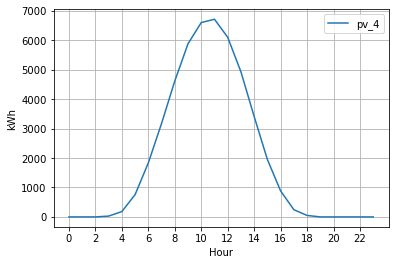

In [59]:
data = pd.read_csv('pv_forecast_data/energy_pv_id=30_pv_4.csv')
data['interval'] = pd.to_datetime(data['interval'])
data = data.set_index('interval')
data = data.groupby(['hour_day']).mean()
data.plot(kind='line', y='Power (W)', grid=True, label='pv_4', ylabel='kWh', xlabel='Hour')
plt.xticks(np.arange(0,24, 2))
plt.savefig('data_verification/pv_forecast/pv_forecast_hour.pdf',bbox_inches='tight')

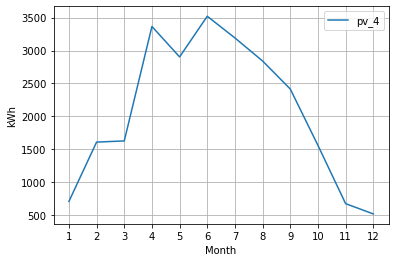

In [58]:
data = pd.read_csv('pv_forecast_data/energy_pv_id=30_pv_4.csv')
data['interval'] = pd.to_datetime(data['interval'])
data = data.set_index('interval')
data = data.groupby(['month']).mean()

data.plot(kind='line', y='Power (W)', grid=True, label='pv_4', ylabel='kWh', xlabel='Month')
plt.xticks(np.arange(1,13, 1))
plt.savefig('data_verification/pv_forecast/pv_forecast_month.pdf',bbox_inches='tight')

In [3]:
data = pd.read_csv('pv_forecast_data/energy_pv_id=30_pv_4.csv')
# Split into X and y
#X = data[['Power (W)','temperature', 'radiation_surface', 'cloud_cover', 'month', 'hour_day', 'available']].values # input
X = data[['Power (W)']].values
y = data[['Power (W)']].values # only predict energy consumption
# Ensure all data is float
#values = values.astype('float32')
# Scale the data
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

window = 1 # or lag, input of how many previous data points used to predict 
train_length = 28032 # 80% of 2019
total_length = 38016 # 2019 & Jan 2020
test_end = 35040 # 2019

def slice_data(data, fr, to, name):
    result = data[fr:to,:]
    # Check shape
    print(name + ": start at " + str(fr) + " - shape: " + str(result.shape))
    return result

# Adjust y (y starts [window] after X)
n_features = X.shape[1]
trainX = slice_data(X, 0, test_end, 'x') # 0 to 28032
trainy = slice_data(y, window, (test_end+window), 'y') # 1 to 28033, depending on the window
# Reshape in 3D input format
trainX = np.reshape(trainX, (trainX.shape[0], window, n_features))
print(trainX.shape, trainy.shape)

x: start at 0 - shape: (35040, 1)
y: start at 1 - shape: (35040, 1)
(35040, 1, 1) (35040, 1)


Epoch 1/50
28/28 [==============================] - 3s 24ms/step - loss: 0.0916 - val_loss: 0.0187
Epoch 2/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0608 - val_loss: 0.0334
Epoch 3/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0442 - val_loss: 0.0237
Epoch 4/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0279 - val_loss: 0.0098
Epoch 5/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0144 - val_loss: 0.0042
Epoch 6/50
28/28 [==============================] - 0s 16ms/step - loss: 0.0081 - val_loss: 0.0027
Epoch 7/50
28/28 [==============================] - 0s 10ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 8/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 9/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 10/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 11/

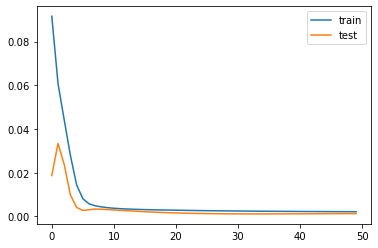

Test MSE: 178764.897
Test RMSE: 422.806


In [4]:
" Simple model """
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
model.compile(loss="mse", optimizer="adam")
#model.summary()

# fit network
history = model.fit(trainX, trainy, epochs=50, batch_size=1024, validation_split=0.2, verbose=1, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.layers import concatenate

# Predict values for Jan 2020
# Prepare input 
forecastX = X[test_end-window:total_length-window]
# Prepare real energy consumption
real_y = y[test_end:]
# Reshape to required format and predict
forecastX = np.reshape(forecastX, (forecastX.shape[0], window, n_features))
forecasted_y = model.predict(forecastX)
# invert scaling
inv_yhat = scaler.inverse_transform(forecasted_y)
inv_y = scaler.inverse_transform(real_y)
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)

Epoch 1/50
28/28 [==============================] - 8s 78ms/step - loss: 0.1075 - val_loss: 0.0190
Epoch 2/50
28/28 [==============================] - 1s 42ms/step - loss: 0.0811 - val_loss: 0.0296
Epoch 3/50
28/28 [==============================] - 1s 32ms/step - loss: 0.0495 - val_loss: 0.0384
Epoch 4/50
28/28 [==============================] - 1s 48ms/step - loss: 0.0245 - val_loss: 0.0099
Epoch 5/50
28/28 [==============================] - 1s 52ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 6/50
28/28 [==============================] - 1s 48ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 7/50
28/28 [==============================] - 1s 45ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 8/50
28/28 [==============================] - 2s 57ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 9/50
28/28 [==============================] - 2s 56ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 10/50
28/28 [==============================] - 2s 56ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 11/

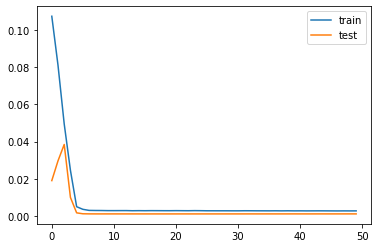

Test MSE: 144344.239
Test RMSE: 379.927


In [4]:
""" Complex model2 """
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

dropout = 0.2
model2 = Sequential()
model2.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model2.add(Dropout(dropout))
model2.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model2.add(Dropout(dropout))
model2.add(Dense(16, activation="relu", kernel_initializer="uniform"))
model2.add(Dense(1, activation="relu", kernel_initializer="uniform"))
model2.compile(loss="mse", optimizer="adam")
#model2.summary()

# fit network
history2 = model2.fit(trainX, trainy, epochs=50, batch_size=1024, validation_split=0.2, verbose=1, shuffle=False)

# plot history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.layers import concatenate

# Predict values for Jan 2020
# Prepare input 
forecastX2 = X[test_end-window:total_length-window]
# Prepare real energy consumption
real_y2 = y[test_end:]
# Reshape to required format and predict
forecastX2 = np.reshape(forecastX2, (forecastX2.shape[0], window, n_features))
forecasted_y2 = model2.predict(forecastX2)
# invert scaling
inv_yhat2 = scaler.inverse_transform(forecasted_y2)
inv_y2 = scaler.inverse_transform(real_y2)
# calculate MSE & RMSE
mse2 = mean_squared_error(inv_y2, inv_yhat2)
rmse2 = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Test MSE: %.3f' % mse2)
print('Test RMSE: %.3f' % rmse2)

In [2]:
del model, model2

NameError: name 'model' is not defined

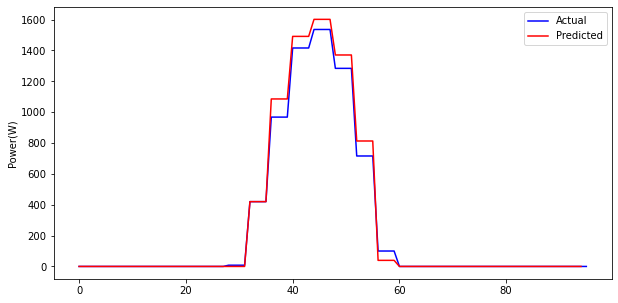

In [9]:
steps = 96
start = 1344
plt.figure(figsize=(10, 5))
plt.plot(inv_y2[:steps], label='Actual', color="blue")
plt.plot(inv_yhat2[1:steps], label='Predicted', color="red")
plt.ylabel("Power(W)")
#plt.title("Actual Vs Predicted Results")
plt.legend()
plt.savefig('data_verification/pv_forecast/pv_chunk_1stJan_2020.pdf',bbox_inches='tight')
#plt.show()

In [4]:
df = pd.DataFrame()
df['interval'] = (pd.DataFrame(columns=['INTERVAL'],
                  index=pd.date_range('2020-01-01T00:00:00Z', '2020-01-31T23:45:00Z',
                                      freq='15T'))
       #.between_time('0:00','23:59')
       .index.strftime('%Y-%m-%dT%H:%M')
       .tolist()
        )
#df['Actual'] = inv_y
df['Power (W)'] = inv_yhat
#df.head(48)
df.to_csv('pv_forecast_data/forecast_pv_d3a_format/pv_forecast_id=30_pv=4.csv', index=False)

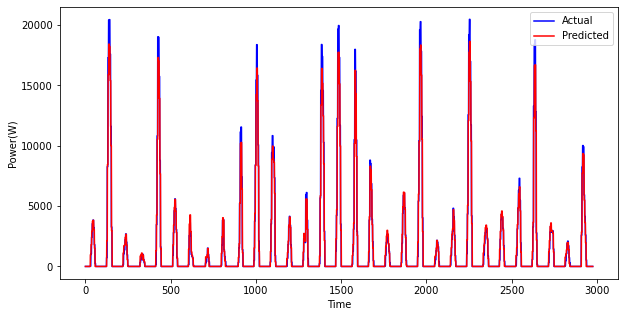

In [15]:
actual = pd.read_csv('pv_forecast_data/energy_pv_id=150_pv_1.csv')
actual = actual['Power (W)'].tail(2976).values
predicted = pd.read_csv('pv_forecast_data/forecast_pv_d3a_format/pv_forecast_id=150_pv=1.csv')
#predicted = predicted['Power (W)'].values
predicted['actual'] = actual
steps = 2976
plt.figure(figsize=(10, 5))
plt.plot(predicted['actual'][:steps], label='Actual', color="blue")
plt.plot(predicted['Power (W)'][:steps], label='Predicted', color="red")
#plt.xticks(index)
plt.xlabel('Time')
plt.ylabel("Power(W)")
#plt.title("Forecast January 2020: pv 4")
plt.legend()
plt.savefig('data_verification/pv_forecast/pv_result_pv1.pdf',bbox_inches='tight')
plt.show()